In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [83]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [84]:
class DNN_2(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2,dropout3,dropout4):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16,8)
        self.layer4 = nn.Linear(8,4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)


        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [85]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [86]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)

    # モデル定義
    model = DNN_2(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()  
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [87]:
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:22,515] A new study created in memory with name: no-name-4439f4ec-c3a4-4ea3-8f15-c4300b479f3f
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:26,835] Trial 0 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.35000000000000003, 'learning_rate': 0.0013634851539990848, 'weight_rate': 0.05322248837063794}. Best is t

Early stopping at epoch 29
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:28,785] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.45, 'learning_rate': 0.04787397350168718, 'weight_rate': 0.04336235490099561}. Best is trial 0 with value: 0.0.


Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:32,430] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.0, 'learning_rate': 0.006260529006558586, 'weight_rate': 0.019996177272896088}. Best is trial 0 with value: 0.0.


Early stopping at epoch 28
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:34,456] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.2, 'dropout2': 0.25, 'dropout3': 0.0, 'dropout4': 0.1, 'learning_rate': 0.06236422306860886, 'weight_rate': 0.004201271832251152}. Best is trial 0 with value: 0.0.


Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:39,144] Trial 4 finished with value: 0.0 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'dropout3': 0.1, 'dropout4': 0.05, 'learning_rate': 0.016256332040665428, 'weight_rate': 0.0002508036584950147}. Best is trial 0 with value: 0.0.


Early stopping at epoch 32
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:41,119] Trial 5 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.15000000000000002, 'dropout4': 0.45, 'learning_rate': 0.022218367368095755, 'weight_rate': 0.02164387211390949}. Best is trial 0 with value: 0.0.


Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:01:54,945] Trial 6 finished with value: 0.043773258469189696 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'dropout3': 0.0, 'dropout4': 0.4, 'learning_rate': 0.0001060883292818629, 'weight_rate': 0.0013025603590144333}. Best is trial 6 with value: 0.043773258469189696.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning

Final MCC: 0.0438


[I 2024-12-12 21:01:55,277] Trial 8 pruned. 
[I 2024-12-12 21:02:05,783] Trial 9 finished with value: 0.15397534484299077 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.0, 'dropout3': 0.35000000000000003, 'dropout4': 0.25, 'learning_rate': 0.0006300618671817703, 'weight_rate': 0.010811629261275902}. Best is trial 9 with value: 0.15397534484299077.


Early stopping at epoch 75
Final MCC: 0.1540


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:02:13,501] Trial 10 finished with value: 0.14264041926468363 and parameters: {'dropout1': 0.0, 'dropout2': 0.0, 'dropout3': 0.5, 'dropout4': 0.2, 'learning_rate': 0.0006892167663678926, 'weight_rate': 0.00418261783253874}. Best is trial 9 with value: 0.15397534484299077.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform

Early stopping at epoch 55
Final MCC: 0.1426


[I 2024-12-12 21:02:13,859] Trial 12 pruned. 
[I 2024-12-12 21:02:17,247] Trial 13 finished with value: 0.1546756884002875 and parameters: {'dropout1': 0.0, 'dropout2': 0.05, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0019249631063766716, 'weight_rate': 0.0016612050106104216}. Best is trial 13 with value: 0.1546756884002875.


Early stopping at epoch 23
Final MCC: 0.1547


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:02:23,260] Trial 14 finished with value: 0.23767239924922223 and parameters: {'dropout1': 0.1, 'dropout2': 0.1, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00266996233214904, 'weight_rate': 0.001506050051945407}. Best is trial 14 with value: 0.23767239924922223.
/tmp/ipykernel_1273259/1497034159.py:7: F

Early stopping at epoch 41
Final MCC: 0.2377


[I 2024-12-12 21:02:23,648] Trial 16 pruned. 
[I 2024-12-12 21:02:23,838] Trial 17 pruned. 
[I 2024-12-12 21:02:24,070] Trial 18 pruned. 
[I 2024-12-12 21:02:24,242] Trial 19 pruned. 
[I 2024-12-12 21:02:24,419] Trial 20 pruned. 
[I 2024-12-12 21:02:24,634] Trial 21 pruned. 
[I 2024-12-12 21:02:38,659] Trial 22 finished with value: 0.14285714285714285 and parameters: {'dropout1': 0.25, 'dropout2': 0.05, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00030024965033404865, 'weight_rate': 0.0029417165850287473}. Best is trial 14 with value: 0.23767239924922223.


Final MCC: 0.1429


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:02:46,204] Trial 23 finished with value: 0.0 and parameters: {'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'dropout3': 0.35000000000000003, 'dropout4': 0.30000000000000004, 'learning_rate': 0.001666229597826963, 'weight_rate': 0.010956233665349402}. Best is trial 14 with value: 0.23767239924922223.


Early stopping at epoch 52
Final MCC: 0.0000


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:02:51,102] Trial 24 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.0, 'dropout3': 0.45, 'dropout4': 0.15000000000000002, 'learning_rate': 0.001018348426240359, 'weight_rate': 0.08700445329704838}. Best is trial 14 with value: 0.23767239924922223.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: s

Early stopping at epoch 34
Final MCC: 0.0000


[I 2024-12-12 21:02:51,494] Trial 26 pruned. 
[I 2024-12-12 21:02:51,689] Trial 27 pruned. 
[I 2024-12-12 21:02:51,864] Trial 28 pruned. 
[I 2024-12-12 21:02:52,076] Trial 29 pruned. 
[I 2024-12-12 21:02:52,268] Trial 30 pruned. 
[I 2024-12-12 21:03:06,320] Trial 31 finished with value: 0.26205950537894646 and parameters: {'dropout1': 0.25, 'dropout2': 0.05, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.0003227587906190821, 'weight_rate': 0.0024930675047202143}. Best is trial 31 with value: 0.26205950537894646.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 

Final MCC: 0.2621


[I 2024-12-12 21:03:19,479] Trial 33 finished with value: 0.34396276630384576 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.1, 'dropout3': 0.35000000000000003, 'dropout4': 0.1, 'learning_rate': 0.0004714902923662284, 'weight_rate': 0.0018163727899163284}. Best is trial 33 with value: 0.34396276630384576.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:03:19,672] Trial 34 p

Early stopping at epoch 97
Final MCC: 0.3440


[I 2024-12-12 21:03:19,853] Trial 35 pruned. 
[I 2024-12-12 21:03:20,047] Trial 36 pruned. 
[I 2024-12-12 21:03:20,243] Trial 37 pruned. 
[I 2024-12-12 21:03:20,407] Trial 38 pruned. 
[I 2024-12-12 21:03:20,599] Trial 39 pruned. 
[I 2024-12-12 21:03:20,795] Trial 40 pruned. 
[I 2024-12-12 21:03:20,980] Trial 41 pruned. 
[I 2024-12-12 21:03:21,168] Trial 42 pruned. 
[I 2024-12-12 21:03:21,341] Trial 43 pruned. 
[I 2024-12-12 21:03:34,894] Trial 44 finished with value: 0.3444700451315692 and parameters: {'dropout1': 0.4, 'dropout2': 0.05, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.00011910933854871215, 'weight_rate': 0.001718139880432988}. Best is trial 44 with value: 0.3444700451315692.


Final MCC: 0.3445


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:03:48,714] Trial 45 finished with value: 0.17635143244924836 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00019041568169889548, 'weight_rate': 0.0007158942621487832}. Best is trial 44 with value: 0.3444700451315692.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning

Final MCC: 0.1764


[I 2024-12-12 21:03:49,121] Trial 47 pruned. 
[I 2024-12-12 21:03:49,301] Trial 48 pruned. 
[I 2024-12-12 21:03:49,507] Trial 49 pruned. 
[I 2024-12-12 21:03:49,694] Trial 50 pruned. 
[I 2024-12-12 21:03:49,898] Trial 51 pruned. 
[I 2024-12-12 21:03:50,097] Trial 52 pruned. 
[I 2024-12-12 21:04:03,632] Trial 53 finished with value: 0.28775870559609923 and parameters: {'dropout1': 0.4, 'dropout2': 0.05, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.0003056444529439143, 'weight_rate': 0.0010422112912051673}. Best is trial 44 with value: 0.3444700451315692.


Early stopping at epoch 97
Final MCC: 0.2878


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:04:03,832] Trial 54 pruned. 
[I 2024-12-12 21:04:13,444] Trial 55 finished with value: 0.23693309452279648 and parameters: {'dropout1': 0.45, 'dropout2': 0.1, 'dropout3': 0.4, 'dropout4': 0.0, 'learning_rate': 0.0004855126853486003, 'weight_rate': 0.0007332266782089724}. Best is trial 44 with value: 0.3444700451315692.
/tmp/ipykernel_1273259/1

Early stopping at epoch 71
Final MCC: 0.2369


[I 2024-12-12 21:04:13,839] Trial 57 pruned. 
[I 2024-12-12 21:04:27,656] Trial 58 finished with value: 0.3332510268386273 and parameters: {'dropout1': 0.45, 'dropout2': 0.0, 'dropout3': 0.4, 'dropout4': 0.05, 'learning_rate': 0.00022853789876006405, 'weight_rate': 0.0014277527231443524}. Best is trial 44 with value: 0.3444700451315692.
/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:04:27,

Final MCC: 0.3333


[I 2024-12-12 21:04:28,046] Trial 60 pruned. 
[I 2024-12-12 21:04:28,229] Trial 61 pruned. 
[I 2024-12-12 21:04:28,404] Trial 62 pruned. 
[I 2024-12-12 21:04:28,581] Trial 63 pruned. 
[I 2024-12-12 21:04:28,779] Trial 64 pruned. 
[I 2024-12-12 21:04:42,702] Trial 65 finished with value: 0.1031769275314795 and parameters: {'dropout1': 0.45, 'dropout2': 0.05, 'dropout3': 0.4, 'dropout4': 0.0, 'learning_rate': 0.0003367899417398978, 'weight_rate': 0.0003899107871815392}. Best is trial 44 with value: 0.3444700451315692.


Final MCC: 0.1032


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:04:42,920] Trial 66 pruned. 
[I 2024-12-12 21:04:55,891] Trial 67 finished with value: 0.3127037834952593 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.05, 'learning_rate': 0.00011781741358211558, 'weight_rate': 0.0011972365521547934}. Best is trial 44 with value: 0.3444700451315692.
/tmp/ipy

Final MCC: 0.3127


[I 2024-12-12 21:05:09,606] Trial 69 finished with value: 0.29502483793993867 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.00013275269586147454, 'weight_rate': 0.0011950174618561489}. Best is trial 44 with value: 0.3444700451315692.


Final MCC: 0.2950


/tmp/ipykernel_1273259/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1273259/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-12 21:05:09,809] Trial 70 pruned. 
[I 2024-12-12 21:05:10,004] Trial 71 pruned. 
[I 2024-12-12 21:05:10,210] Trial 72 pruned. 
[I 2024-12-12 21:05:10,407] Trial 73 pruned. 
[I 2024-12-12 21:05:10,625] Trial 74 pruned. 
[I 2024-12-12 21:05:10,821] Trial 75 pruned. 
[I 2024-12-12 21:05:11,030] Trial 76 pruned. 
[I 2024-12-12 21:05:11,229] Trial 77 pru

Early stopping at epoch 78
Final MCC: 0.0000


[I 2024-12-12 21:05:23,525] Trial 86 pruned. 
[I 2024-12-12 21:05:23,720] Trial 87 pruned. 
[I 2024-12-12 21:05:23,894] Trial 88 pruned. 
[I 2024-12-12 21:05:24,051] Trial 89 pruned. 
[I 2024-12-12 21:05:24,260] Trial 90 pruned. 
[I 2024-12-12 21:05:24,450] Trial 91 pruned. 
[I 2024-12-12 21:05:24,634] Trial 92 pruned. 
[I 2024-12-12 21:05:24,813] Trial 93 pruned. 
[I 2024-12-12 21:05:24,983] Trial 94 pruned. 
[I 2024-12-12 21:05:25,161] Trial 95 pruned. 
[I 2024-12-12 21:05:25,337] Trial 96 pruned. 
[I 2024-12-12 21:05:25,537] Trial 97 pruned. 
[I 2024-12-12 21:05:25,717] Trial 98 pruned. 
[I 2024-12-12 21:05:25,904] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.05, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.00011910933854871215, 'weight_rate': 0.001718139880432988}
Best Validation F1:  0.3444700451315692


In [88]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_2_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/500], Loss: 0.7382
Epoch [1/500], Train Loss: 0.7382, Val Loss: 0.7248
Epoch [2/500], Loss: 0.7408
Epoch [2/500], Train Loss: 0.7408, Val Loss: 0.7204
Epoch [3/500], Loss: 0.7269
Epoch [3/500], Train Loss: 0.7269, Val Loss: 0.7176
Epoch [4/500], Loss: 0.7252
Epoch [4/500], Train Loss: 0.7252, Val Loss: 0.7150
Epoch [5/500], Loss: 0.7156
Epoch [5/500], Train Loss: 0.7156, Val Loss: 0.7133
Epoch [6/500], Loss: 0.7175
Epoch [6/500], Train Loss: 0.7175, Val Loss: 0.7089
Epoch [7/500], Loss: 0.7081
Epoch [7/500], Train Loss: 0.7081, Val Loss: 0.7099
Epoch [8/500], Loss: 0.7089
Epoch [8/500], Train Loss: 0.7089, Val Loss: 0.7052
Epoch [9/500], Loss: 0.7114
Epoch [9/500], Train Loss: 0.7114, Val Loss: 0.7023
Epoch [10/500], Loss: 0.6983
Epoch [10/500], Train Loss: 0.6983, Val Loss: 0.7014
Epoch [11/500], Loss: 0.7050
Epoch [11/500], Train Loss: 0.7050, Val Loss: 0.6979
Epoch [12/500], Loss: 0.6927
Epoch [12/500], Train Loss: 0.6927, Val Loss: 0.6943
Epoch [13/500], Loss: 0.6940
Epoch

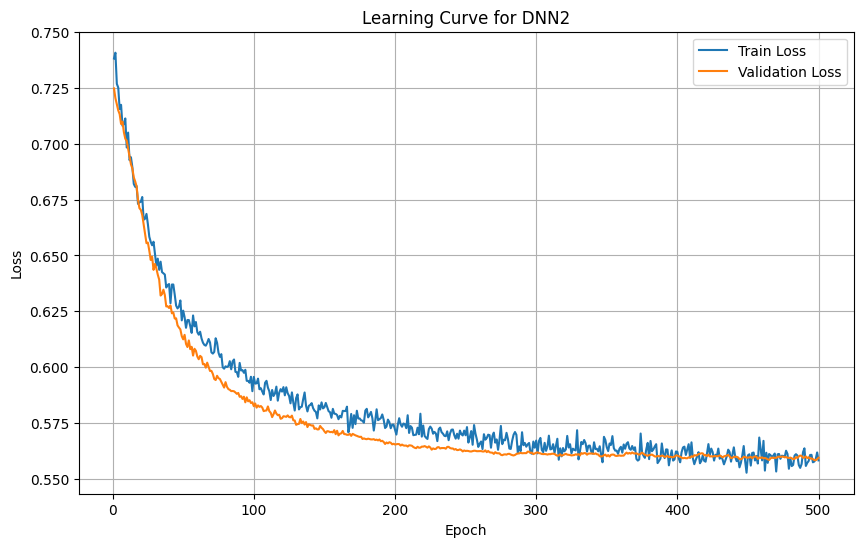

In [98]:
best_params=study.best_params
model = DNN_2(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_rate"])
criterion = nn.BCELoss()

num_epochs=500
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN2')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.16%
Precision: 0.4976
Recall: 0.6106
F1 Score: 0.5483
Matthews Correlation Coefficient: 0.2173
Specificity: 0.6122


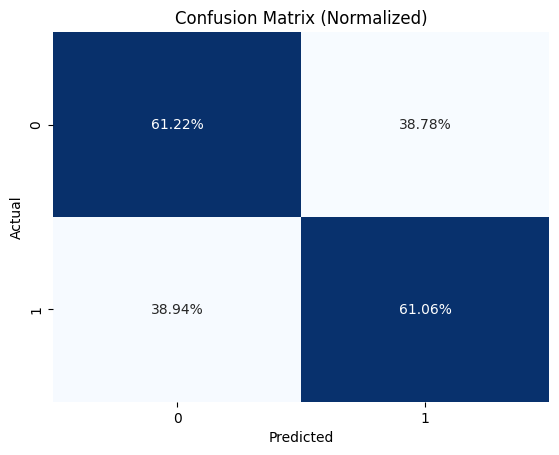

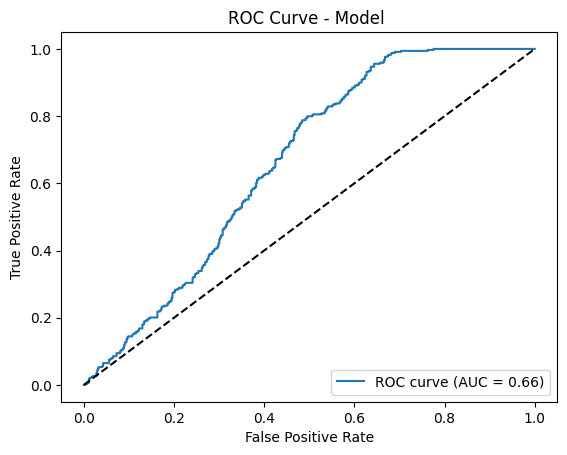

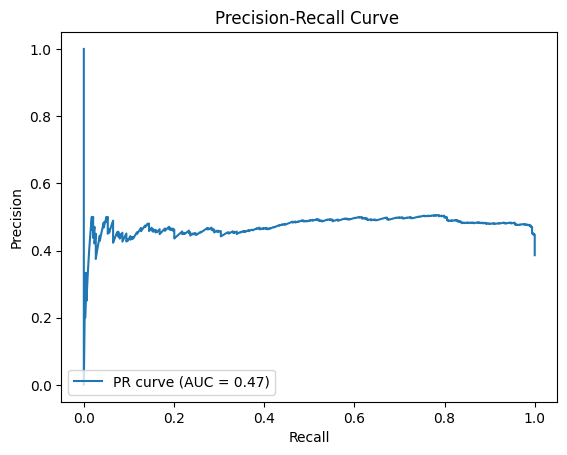

In [99]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [91]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_2.pth')



In [92]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 8]             136
       BatchNorm1d-8                    [-1, 8]              16
           Dropout-9                    [-1, 8]               0
           Linear-10                    [-1, 4]              36
      BatchNorm1d-11                    [-1, 4]               8
          Dropout-12                    [-1, 4]               0
           Linear-13                    [-1, 1]               5
Total params: 1,785
Trainable params: 1